In [1]:
# Imports and Notebook setup
from timeit import timeit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rrmpg.models import HBVEdu
from rrmpg.data import CAMELSLoader
from rrmpg.tools.monte_carlo import monte_carlo
from rrmpg.utils.metrics import calc_nse
from sklearn.metrics import balanced_accuracy_score


In [2]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
import pickle
import shap
import itertools
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem

from scipy.optimize import minimize



## Load data

In [3]:
df = CAMELSLoader().load_basin('01031500')
df.head()

,dayl(s),prcp(mm/day),srad(W/m2),swe(mm),tmax(C),tmin(C),vp(Pa),PET,QObs(mm/d)
1980-10-01,41050.80,0.00,286.90,0.0,16.19,4.31,825.78,1.5713,0.5550
1980-10-02,40780.81,2.08,195.94,0.0,13.46,5.72,920.18,1.2619,0.4979
1980-10-03,40435.21,5.57,172.60,0.0,17.84,8.61,1128.70,1.2979,0.5169
1980-10-04,40435.21,23.68,170.45,0.0,16.28,7.32,1027.91,1.2251,1.5634
1980-10-05,40089.58,3.00,113.83,0.0,10.51,5.01,881.61,0.9116,2.8541


In [4]:
### HBV Parameters
# temp: Calculate the array of (mean) temperature for each timestep.
qobs = df["QObs(mm/d)"]
temp = (df["tmax(C)"]+ df["tmin(C)"])/2
df["mean_temp"] = (df["tmax(C)"]+ df["tmin(C)"])/2
prec = df["prcp(mm/day)"]
month = df.index.month
df["month_index"] = df.index.month

df['year']=df.index.year
df["month"]=df.index.month

monthly_pet = df.groupby(['year','month'])['PET'].mean().reset_index()
long_term_pet = monthly_pet.groupby('month')['PET'].mean().reset_index()

monthly_temp = df.groupby(['year','month'])['mean_temp'].mean().reset_index()
long_term_temp = monthly_temp.groupby('month')['mean_temp'].mean().reset_index()

long_term_temp

# prec: Array of (summed) precipitation for each timestep. [mm/day]

# month: Array of integers indicating for each timestep to which month it belongs [1,2, …, 12]. Used for adjusted potential evapotranspiration.

# PE_m: long-term mean monthly potential evapotranspiration.

# T_m: long-term mean monthly temperature.


,month,mean_temp
0,1,-10.861082
1,2,-9.030222
2,3,-3.853714
3,4,3.553912
4,5,10.386352
5,6,15.647392
6,7,18.539288
7,8,17.596973
8,9,13.042118
9,10,6.522894


Split the data into a calibration period and validation period. As in the CAMELS data set publication, we will use the first 15 hydrological years for calibration. The rest of the data will be used for validation.


In [5]:
# calcute the end date of the calibration period
end_cal = pd.to_datetime(f"{df.index[0].year + 15}/09/30", yearfirst=True)

# validation period starts one day later
start_val = end_cal + pd.DateOffset(days=1)

# split the data into two and save csv files
cal = df[:end_cal].copy()
val = df[start_val:].copy()
cal.to_csv('data/train.csv')
val.to_csv('data/test.csv')

## Fit the HBVEdu model to observed discharge

### Using one of SciPy's global optimizer


In [6]:
# calculate mean temp for calibration and validation period
cal['tmean'] = (cal['tmin(C)'] + cal['tmax(C)']) / 2
val['tmean'] = (val['tmin(C)'] + val['tmax(C)']) / 2

# load the gauge station height
height = CAMELSLoader().get_station_height('01031500')

In [7]:
# Load the pre-fitted initial HBVEdu model
with open('model/optimization_result.pkl', 'rb') as f:
    result = pickle.load(f)

result

Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.


 message: Optimization terminated successfully.
 success: True
     fun: 4.0093799696884975
       x: [-1.716e-01  3.147e+00  1.737e+02  2.247e+00  6.198e-02
            1.580e+02  1.695e-01  9.924e-02  4.117e-02  4.976e-02
            4.815e+00]
     nit: 16
    nfev: 3921

`result` is an object defined by the scipy library and contains the optimized model parameters, as well as some more information on the optimization process.

In [8]:
result

 message: Optimization terminated successfully.
 success: True
     fun: 4.0093799696884975
       x: [-1.716e-01  3.147e+00  1.737e+02  2.247e+00  6.198e-02
            1.580e+02  1.695e-01  9.924e-02  4.117e-02  4.976e-02
            4.815e+00]
     nit: 16
    nfev: 3921


- `fun` is the final value of our optimization criterion (the mean-squared-error)
- `message` describes the cause of the optimization termination
- `nfev` is the number of model simulations
- `sucess` is a flag wether or not the optimization was successful
- `x` are the optimized model parameters

Next, let us set the model parameters to the optimized ones found by the search. Therefore we need to create a dictonary containing one key for each model parameter and as the corresponding value the optimized parameter. As mentioned before, the list of model parameter names can be retrieved by the `model.get_parameter_names()` function. We can then create the needed dictonary by the following lines of code:

In [9]:
params = {}
model = HBVEdu()
param_names = model.get_parameter_names()

for i, param in enumerate(param_names):
    params[param] = result.x[i]

model.set_params(params)
model.get_params()

{'T_t': -0.1715714214386017,
 'DD': 3.1465838464605698,
 'FC': 173.74361393207556,
 'Beta': 2.247123308555528,
 'C': 0.06197731339524527,
 'PWP': 157.95969827223382,
 'K_0': 0.16949130903282178,
 'K_1': 0.09923979096992544,
 'K_2': 0.04117405437760092,
 'K_p': 0.04975978275618893,
 'L': 4.815004355815933}

## Calculate simulated discharge

The simulated streamflow of the model. model has a `.simulate()` method, that returns the simulated discharge for the inputs we provide to this function.

In [10]:

val['qsim_fit'] = model.simulate( val['tmean'], val['prcp(mm/day)'], 
                   val['month_index'], long_term_pet['PET'], long_term_temp['mean_temp'])

# Calculate and print the Nash-Sutcliff-Efficiency for both simulations
nse_fit = calc_nse(val['QObs(mm/d)'], val['qsim_fit'])

print("NSE of the .fit() optimization: {:.4f}".format(nse_fit))

NSE of the .fit() optimization: 0.6542


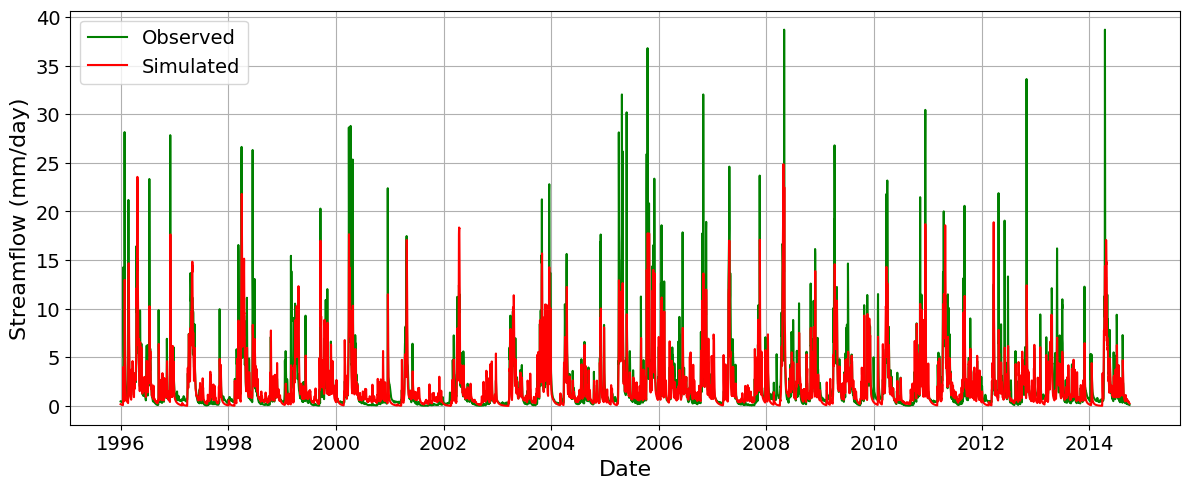

In [11]:
# Plot last full hydrological year of the simulation
%matplotlib inline
plt.figure(figsize=(12, 5))

start_date = pd.to_datetime("1996/01/01", yearfirst=True)
end_date = pd.to_datetime("2014/09/30", yearfirst=True)
plt.plot(val.loc[start_date:end_date, 'QObs(mm/d)'], label='Observed', color='green')
plt.plot(val.loc[start_date:end_date, 'qsim_fit'], label='Simulated', color = 'red')

plt.xlabel('Date', fontsize=16)  
plt.ylabel('Streamflow (mm/day)', fontsize=16)  
plt.legend(fontsize=14)  


plt.grid(True) 
plt.xticks(rotation=0, fontsize=14)  
plt.yticks(fontsize=14) 

plt.tight_layout()  
plt.savefig('img/streamflow_comparison.png', dpi=300)  
plt.show()


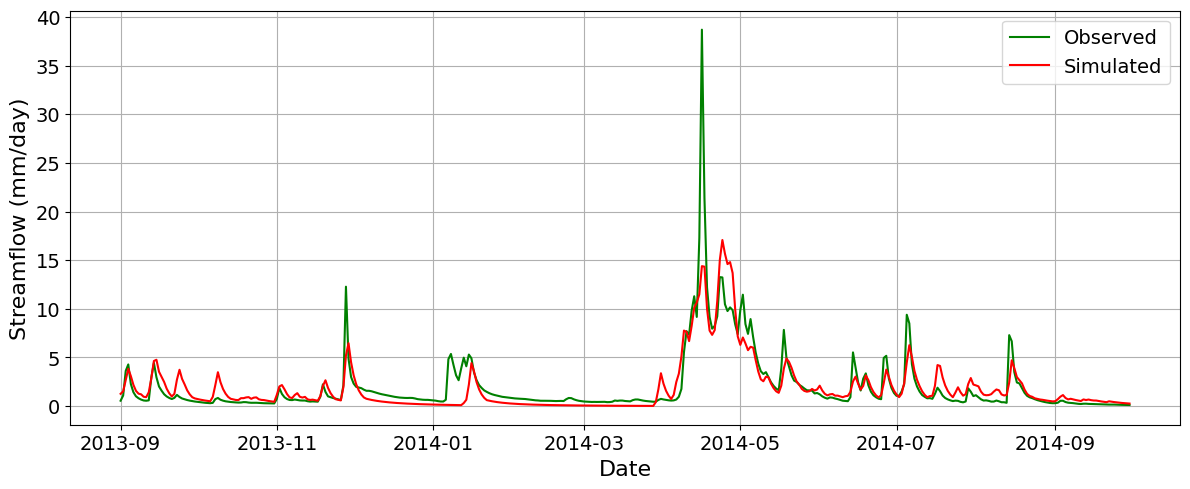

In [12]:
# Plot last full hydrological year of the simulation
%matplotlib inline
plt.figure(figsize=(12, 5))

start_date = pd.to_datetime("2013/09/01", yearfirst=True)
end_date = pd.to_datetime("2014/09/30", yearfirst=True)
plt.plot(val.loc[start_date:end_date, 'QObs(mm/d)'], label='Observed', color='green')
plt.plot(val.loc[start_date:end_date, 'qsim_fit'], label='Simulated', color = 'red')

plt.xlabel('Date', fontsize=16) 
plt.ylabel('Streamflow (mm/day)', fontsize=16) 
plt.legend(fontsize=14)

plt.grid(True) 
plt.xticks(rotation=0, fontsize=14) 
plt.yticks(fontsize=14)

plt.tight_layout() 
plt.savefig('img/streamflow_comparison2.png', dpi=300)
plt.show()


# Finding optimal param values

# Selected ML Model - Random forest

In [13]:
text_data = pd.read_csv('data/weather_data_with_user_text_new_observer.csv')
# brek train and test sets
text_data['date'] = pd.to_datetime(text_data['date'])

# Split the data into two
train_text = text_data[text_data['date'] <= '1995-09-30']
test_text = text_data[text_data['date'] > '1995-09-30']

# merge train text data and train data
cal['user_data'] = cal.index.map(train_text.set_index('date')['user_data'])
val['user_data'] = val.index.map(test_text.set_index('date')['user_data'])
print(text_data.shape, cal.shape, val.shape)

(12418, 6) (5478, 15) (6940, 16)


In [14]:
# Generate the true label column
train = cal.copy()
test = val.copy()

def categorize_precipitation(prcp):
    if prcp >= 11.4:
        return 'wet'
    elif prcp >= 4 and prcp < 11.4:
        return 'moderate'
    else:
        return 'dry'

# create a new label column
train['weather_label'] = train['prcp(mm/day)'].apply(categorize_precipitation)
test['weather_label'] = test['prcp(mm/day)'].apply(categorize_precipitation)

nlp_data_train = train[['user_data', 'weather_label']]
nlp_data_test = test[['user_data', 'weather_label']]

print('labels count in train data\n\n',nlp_data_train[['weather_label']].value_counts())
print('\nlabels count in test data\n\n',nlp_data_test[['weather_label']].value_counts())

test.to_csv('data/test_data_save.csv')
train.to_csv('data/train_data_save.csv')


labels count in train data

 weather_label
dry              4144
moderate          813
wet               521
Name: count, dtype: int64

labels count in test data

 weather_label
dry              5164
moderate         1053
wet               723
Name: count, dtype: int64


In [15]:
nlp_data_train

,user_data,weather_label
1980-10-01,Not a drop of rain today; it feels like the ar...,dry
1980-10-02,A decent rainfall that left the ground well-so...,dry
1980-10-03,"It rained quite heavily, leaving deep puddles ...",moderate
1980-10-04,"It rained quite heavily, leaving deep puddles ...",wet
1980-10-05,Some steady rain brought a refreshing feel to ...,dry
...,...,...
1995-09-26,Enough rain fell to give the plants a good dri...,dry
1995-09-27,A few sprinkles were enough to dampen the eart...,dry
1995-09-28,"A strong rainfall today, making the landscape ...",moderate
1995-09-29,Not a drop of rain today; it feels like the ar...,dry


In [16]:
nlp_data_train = nlp_data_train.copy()
nlp_data_test = nlp_data_test.copy()

# Split the data into train and test sets
X_train = nlp_data_train['user_data']
X_test = nlp_data_test['user_data']
Y_train = nlp_data_train['weather_label']
Y_test = nlp_data_test['weather_label']

# Encode labels
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)  # dry -> 0, moderate -> 1, wet -> 2
Y_test = encoder.transform(Y_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'classifier__class_weight': 'balanced', 'classifier__n_estimators': 20, 'tfidf__max_features': 50, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': 'english'}
Best Cross-Validation Accuracy: 0.714541067848243

Train Accuracy: 0.7423366491787107

Classification Report Train:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      4144
           1       0.67      0.63      0.65       813
           2       0.49      0.62      0.55       521

    accuracy                           0.89      5478
   macro avg       0.72      0.74      0.73      5478
weighted avg       0.90      0.89      0.90      5478


Test Accuracy: 0.7083225921345734

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99      5164
           1       0.60      0.57      0.58      1053
           2       0.46      0.59     

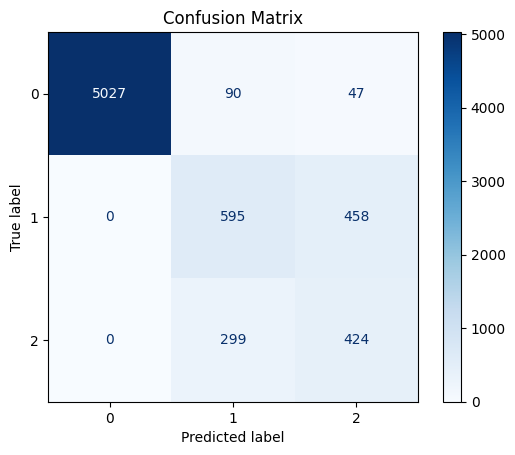

In [17]:
# Selected this model based on results of NLP_model_training.ipynb file 
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'tfidf__max_features': [10, 50, 100],             
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)], 
    'tfidf__stop_words': ['english'], 
    'classifier__n_estimators': [20, 50, 75, 100],                     
    'classifier__class_weight': ['balanced']
}

grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='balanced_accuracy', 
    verbose=1, 
    n_jobs=-1
)

grid_search.fit(X_train, Y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

y_pred_train = grid_search.best_estimator_.predict(X_train)
print("\nTrain Accuracy:", balanced_accuracy_score(Y_train, y_pred_train))
print("\nClassification Report Train:\n", classification_report(Y_train, y_pred_train))

y_pred = grid_search.best_estimator_.predict(X_test)
print("\nTest Accuracy:", balanced_accuracy_score(Y_test, y_pred))
print("\nClassification Report:\n", classification_report(Y_test, y_pred))

train['predicted_labels'] = y_pred_train
test['predicted_labels'] = y_pred

cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.named_steps['classifier'].classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()



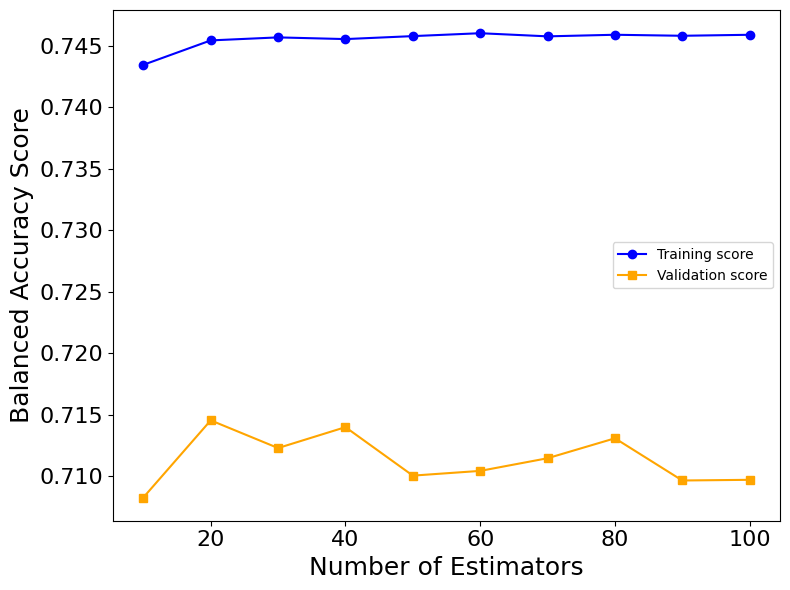

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

pipeline = grid_search.best_estimator_
param_name = 'classifier__n_estimators'
param_range = [10,20,30,40,50,60,70,80,90,100]

# Compute validation curve
train_scores, test_scores = validation_curve(
    pipeline,
    X_train,
    Y_train,
    param_name=param_name,
    param_range=param_range,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1
)

# the mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(param_range, train_mean, label='Training score', marker='o', color='blue')
plt.plot(param_range, test_mean, label='Validation score', marker='s', color='orange')

plt.xlabel('Number of Estimators', fontsize=18)
plt.ylabel('Balanced Accuracy Score', fontsize=18)
plt.legend(loc='best')
plt.xticks(fontsize=16)            
plt.yticks(fontsize=16) 
plt.tight_layout() 
plt.savefig('img/validation_curve.png', dpi=300, bbox_inches='tight')
plt.show()


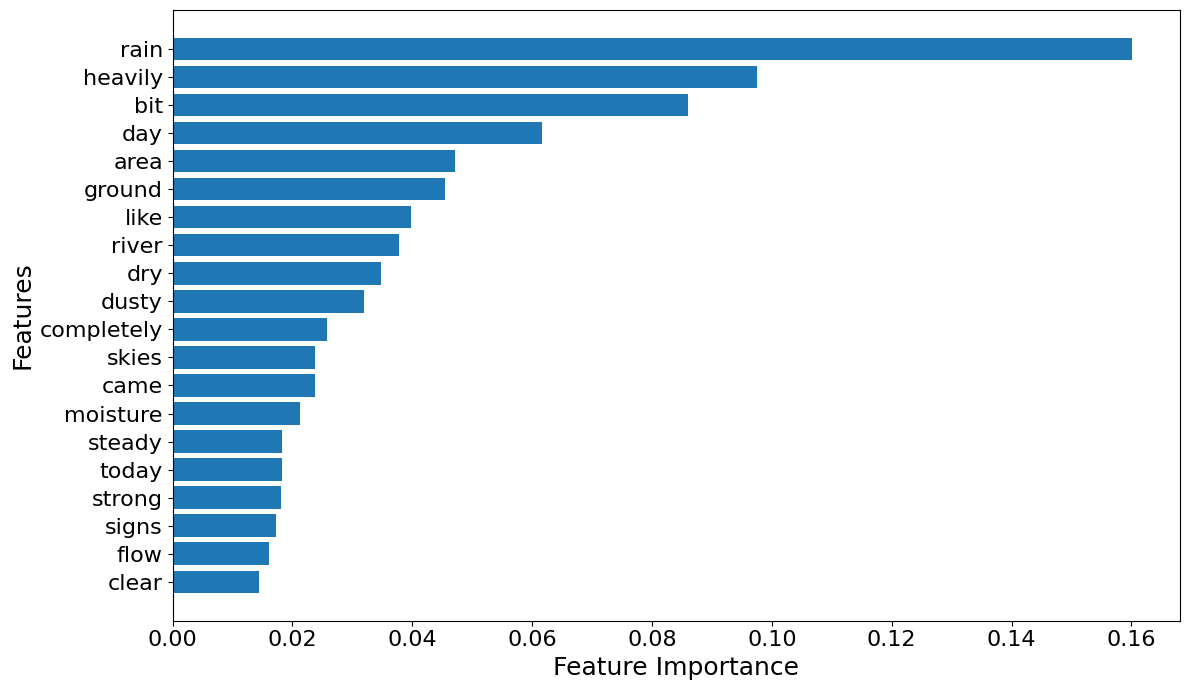

In [19]:
best_pipeline = grid_search.best_estimator_

# get the feature names from the TfidfVectorizer
tfidf_vectorizer = best_pipeline.named_steps['tfidf']
feature_names = tfidf_vectorizer.get_feature_names_out()

# get the feature importances from the model
classifier = best_pipeline.named_steps['classifier']
feature_importances = classifier.feature_importances_

# Sort the features
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = np.array(feature_names)[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

top_n = 20
plt.figure(figsize=(12, 7))
plt.barh(sorted_features[:top_n][::-1], sorted_importances[:top_n][::-1])

plt.xlabel('Feature Importance', fontsize=18) 
plt.ylabel('Features', fontsize=18)           
plt.xticks(fontsize=16)                      
plt.yticks(fontsize=16)      

plt.tight_layout() 
plt.savefig('img/feature_importance_rf_plot.png', dpi=300, bbox_inches='tight')
plt.show()


# Optimization

In [20]:
def evaluate_hbv(parameters, weather_type, data):
    try:
        soil_moisture,beta,pwp,k0, k1 = parameters

        params = {}
        model = HBVEdu()
        param_names = model.get_parameter_names()
        
        for i, param in enumerate(param_names):
            params[param] = result.x[i]
        
        model.set_params(params)

        # Simulate original model
        data['qsim_fit'] = model.simulate(
            data['tmean'], data['prcp(mm/day)'], 
            data['month_index'], long_term_pet['PET'], long_term_temp['mean_temp']
        )
        nse_fit_obs = calc_nse(data['QObs(mm/d)'], data['qsim_fit'])

        # update parameters and simulate again
        original_fc = params['FC']
        original_beta = params['Beta']
        original_pwp = params['PWP']
        original_k0 = params['K_0']
        original_k1 = params['K_1']
            
        params['FC']= original_fc + soil_moisture
        params['Beta'] = original_beta + beta
        params['PWP'] = original_pwp + pwp
        params['K_0'] = original_k0 + k0
        params['K_1'] = original_k1 + k1
        model.set_params(params)

        data['qsim_fit_2'] = model.simulate(
            data['tmean'], data['prcp(mm/day)'], 
            data['month_index'], long_term_pet['PET'], long_term_temp['mean_temp']
        )
        nse_fit_simulated = calc_nse(data['QObs(mm/d)'], data['qsim_fit_2'])

        # calculate NSE improvement
        nse_improvement = nse_fit_simulated - nse_fit_obs
        #print(f"Observed NSE: {nse_fit_obs}, Simulated NSE: {nse_fit_simulated}, Improvement: {nse_improvement}")

        if np.isnan(nse_improvement) or np.isinf(nse_improvement):
            raise ValueError("Invalid NSE improvement value calculated.")

        return -nse_improvement  # get the negative for minimization

    except Exception as e:
        #print(f"Error in evaluate_hbv: {e}")
        return 1e6  # Use a very large value instead of infinity


In [31]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem

class HBVOptimization(Problem):
    def __init__(self, wet_data, dry_data, normal_data):
        super().__init__(n_var=5, n_obj=3, n_constr=0, xl=[-0.1, -0.75, 1.5, 0.0001, 0.05], xu=[50, 3, 30 ,0.05, 0.2])
        self.wet_data = wet_data
        self.dry_data = dry_data
        self.normal_data = normal_data

    def _evaluate(self, X, out, *args, **kwargs):
        F = []
        for params in X:

            # Calculate objective values for wet, dry, and normal days
            obj_wet = evaluate_hbv(params, 'wet', self.wet_data)
            obj_dry = evaluate_hbv(params, 'dry', self.dry_data)
            obj_normal = evaluate_hbv(params, 'normal', self.normal_data)
            
            F.append([obj_wet, obj_dry, obj_normal])
        out["F"] = np.array(F)

# Prepare data for optimization
wet_data = train[train["predicted_labels"] == 2].copy()
dry_data = train[train["predicted_labels"] == 0].copy()
normal_data = train[train["predicted_labels"] == 1].copy()

np.random.seed(23) 
problem = HBVOptimization(wet_data, dry_data, normal_data)
np.random.seed(23)
algorithm = NSGA2(pop_size=1000)

results_ = minimize(problem, algorithm, termination=('n_gen', 200), seed=23, verbose=True)

optimized_parameters = results_.X

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |     1000 |     40 |             - |             -
     2 |     2000 |     81 |  0.0751060166 |         ideal
     3 |     3000 |    116 |  0.0255993486 |         ideal
     4 |     4000 |    157 |  0.0562562905 |         ideal
     5 |     5000 |    235 |  0.0195926244 |         ideal
     6 |     6000 |    312 |  0.0084050203 |         ideal
     7 |     7000 |    387 |  0.0040606562 |         ideal
     8 |     8000 |    519 |  0.0231235942 |         ideal
     9 |     9000 |    721 |  0.0138074042 |         nadir
    10 |    10000 |    913 |  0.0043212851 |         ideal
    11 |    11000 |   1000 |  0.0027171782 |         ideal
    12 |    12000 |   1000 |  0.0025704425 |         ideal
    13 |    13000 |   1000 |  0.0035458939 |             f
    14 |    14000 |   1000 |  0.0092751853 |         nadir
    15 |    15000 |   1000 |  0.0164981916 |         nadir
    16 |    16000 |   1000 |  0.0134599451 |         nad

In [22]:
# Update the HBVEdu model with optimized parameters
acc = []
for i in optimized_parameters:
    soil_moisture, beta, pwp, k0, k1 = i
    params = {}
    model = HBVEdu()
    param_names = model.get_parameter_names()
    
    for i, param in enumerate(param_names):
        params[param] = result.x[i]
    
    model.set_params(params)
    params = model.get_params()
        
    # update parameters and simulate again
    original_fc = params['FC']
    original_beta = params['Beta']
    original_pwp = params['PWP']
    original_k0 = params['K_0']
    original_k1 = params['K_1']
                
    params['FC']= original_fc + soil_moisture
    params['Beta'] = original_beta + beta
    params['PWP'] = original_pwp + pwp
    params['K_0'] = original_k0 + k0
    params['K_1'] = original_k1 + k1
    model.set_params(params)
    
    val['qsim_fit_optimized'] = model.simulate(
                val['tmean'], val['prcp(mm/day)'], 
                val['month_index'], long_term_pet['PET'], long_term_temp['mean_temp']
            )
    nse_fit_simulated = calc_nse(val['QObs(mm/d)'], val['qsim_fit_optimized'])
    acc.append(nse_fit_simulated)

acc.sort(reverse = True)


In [23]:
params = model.get_params()
params


{'T_t': -0.1715714214386017,
 'DD': 3.1465838464605698,
 'FC': 222.90580316921728,
 'Beta': 1.4971414110932388,
 'C': 0.06197731339524527,
 'PWP': 177.99508739228003,
 'K_0': 0.16959635186993088,
 'K_1': 0.19752165405046285,
 'K_2': 0.04117405437760092,
 'K_p': 0.04975978275618893,
 'L': 4.815004355815933}

NSE simulated:  0.6867387388327156


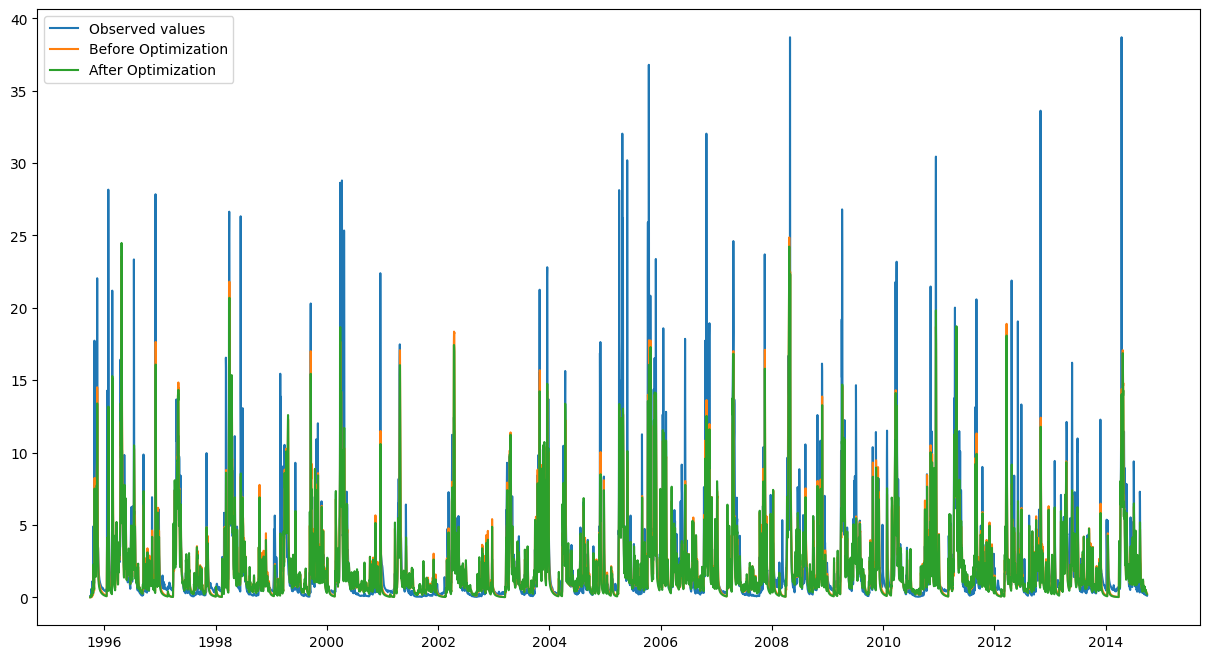

In [24]:
# Update the model with optimized parameters

soil_moisture, beta, pwp, k0, k1 = optimized_parameters[0]
params = {}
model = HBVEdu()
param_names = model.get_parameter_names()
    
for i, param in enumerate(param_names):
    params[param] = result.x[i]
    
model.set_params(params)
params = model.get_params()

# update parameters and simulate again
original_fc = params['FC']
original_beta = params['Beta']
original_pwp = params['PWP']
original_k0 = params['K_0']
original_k1 = params['K_1']

params['FC']= original_fc + soil_moisture
params['Beta'] = original_beta + beta
params['PWP'] = original_pwp + pwp
params['K_0'] = original_k0 + k0
params['K_1'] = original_k1 + k1

if(params['K_1']>params['K_0']):
    diff = params['K_1']- params['K_0']
    params['K_1'] = params['K_1'] - (diff + 1e-2)
    
model.set_params(params)

val['qsim_fit_optimized'] = model.simulate(
            val['tmean'], val['prcp(mm/day)'], 
            val['month_index'], long_term_pet['PET'], long_term_temp['mean_temp']
        )
nse_fit_simulated = calc_nse(val['QObs(mm/d)'], val['qsim_fit_optimized'])

print('NSE simulated: ',nse_fit_simulated)
plt.figure(figsize=(15, 8))
plt.plot(val["QObs(mm/d)"], label="Observed values")
plt.plot(val["qsim_fit"], label="Before Optimization")
plt.plot(val["qsim_fit_optimized"], label="After Optimization")
plt.legend()
plt.show()


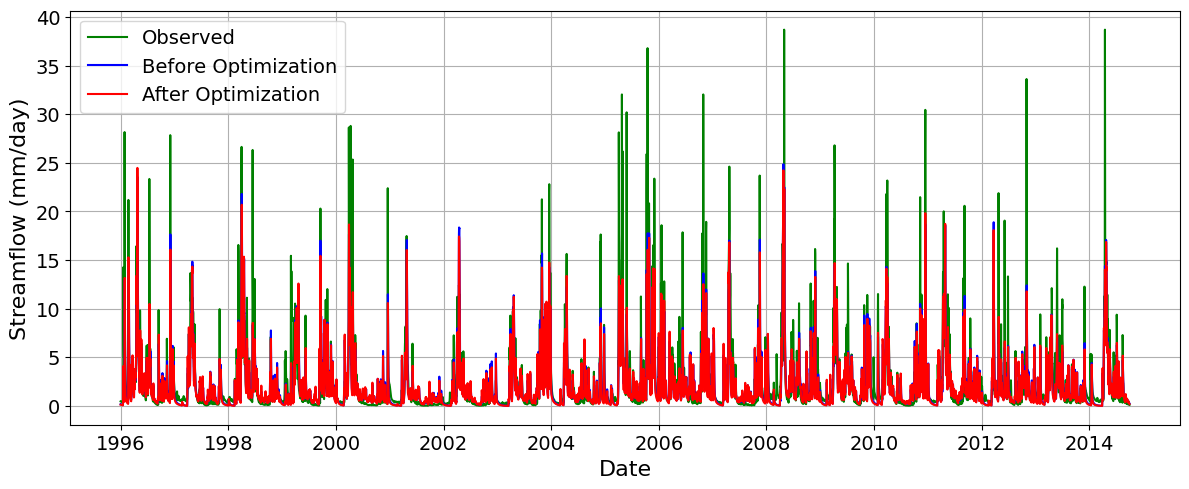

In [25]:
%matplotlib inline
plt.figure(figsize=(12, 5))

start_date = pd.to_datetime("1996/01/01", yearfirst=True)
end_date = pd.to_datetime("2014/09/30", yearfirst=True)
plt.plot(val.loc[start_date:end_date, 'QObs(mm/d)'], label='Observed', color='green')
plt.plot(val.loc[start_date:end_date, 'qsim_fit'], label='Before Optimization', color = 'blue')
plt.plot(val.loc[start_date:end_date, 'qsim_fit_optimized'], label='After Optimization', color = 'red')


plt.xlabel('Date', fontsize=16)  
plt.ylabel('Streamflow (mm/day)', fontsize=16) 
plt.legend(fontsize=14)

plt.grid(True)  
plt.xticks(rotation=0, fontsize=14)  
plt.yticks(fontsize=14)  

# save the figure 
plt.tight_layout()
plt.savefig('img/streamflow_optimized_comparison.png', dpi=300)
plt.show()


In [26]:
model.get_params()


{'T_t': -0.1715714214386017,
 'DD': 3.1465838464605698,
 'FC': 223.74042410097303,
 'Beta': 1.497126181834369,
 'C': 0.06197731339524527,
 'PWP': 159.46114128730895,
 'K_0': 0.16959136527119237,
 'K_1': 0.14924138767999318,
 'K_2': 0.04117405437760092,
 'K_p': 0.04975978275618893,
 'L': 4.815004355815933}

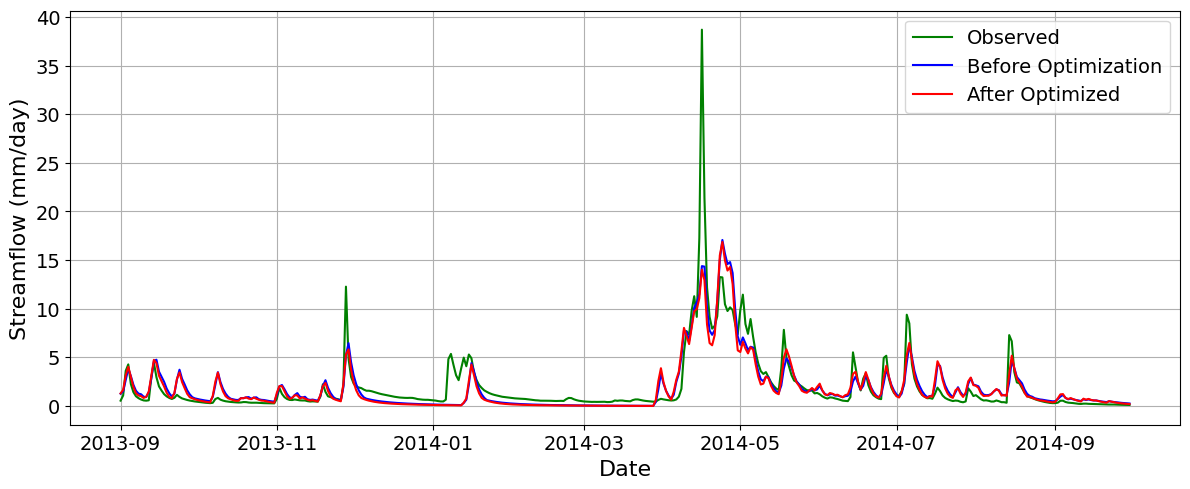

In [27]:
# Plot last full hydrological year of the simulation
%matplotlib inline
plt.figure(figsize=(12, 5))

start_date = pd.to_datetime("2013/09/01", yearfirst=True)
end_date = pd.to_datetime("2014/09/30", yearfirst=True)
plt.plot(val.loc[start_date:end_date, 'QObs(mm/d)'], label='Observed', color='green')
plt.plot(val.loc[start_date:end_date, 'qsim_fit'], label='Before Optimization', color = 'blue')
plt.plot(val.loc[start_date:end_date, 'qsim_fit_optimized'], label='After Optimized', color = 'red')


plt.xlabel('Date', fontsize=16) 
plt.ylabel('Streamflow (mm/day)', fontsize=16)
plt.legend(fontsize=14)  

plt.grid(True)  
plt.xticks(rotation=0, fontsize=14) 
plt.yticks(fontsize=14) 

plt.tight_layout()
plt.savefig('img/streamflow_optimized_short_time.png', dpi=300)
plt.show()


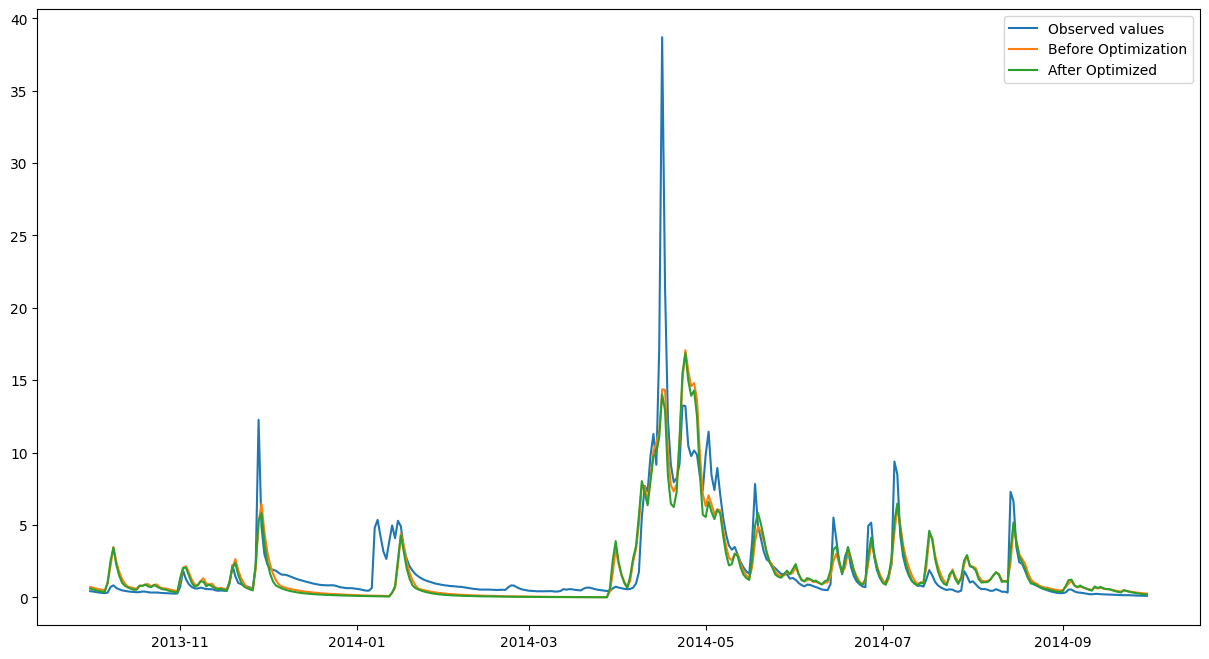

In [28]:
%matplotlib inline
start_date = pd.to_datetime("2013/10/01", yearfirst=True)
end_date = pd.to_datetime("2014/09/30", yearfirst=True)
plt.figure(figsize=(15, 8))

plt.plot(val.loc[start_date:end_date, 'QObs(mm/d)'], label='Observed values')
plt.plot(val.loc[start_date:end_date, 'qsim_fit'], label='Before Optimization')
plt.plot(val.loc[start_date:end_date, 'qsim_fit_optimized'], label='After Optimized')
plt.legend()


In [29]:
result

 message: Optimization terminated successfully.
 success: True
     fun: 4.0093799696884975
       x: [-1.716e-01  3.147e+00  1.737e+02  2.247e+00  6.198e-02
            1.580e+02  1.695e-01  9.924e-02  4.117e-02  4.976e-02
            4.815e+00]
     nit: 16
    nfev: 3921